### Smaller Xception
This notebook will hold information on how we can use the more advacned convnet architecture principles to construct a model that resembles the Xception model. Fun fact, this was proposed by Francis Chollet himself, and engineered by Google!

In [13]:
# setup
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [14]:
# download data
! kaggle competitions download -c dogs-vs-cats
! unzip -qq dogs-vs-cats.zip
! unzip -qq train.zip

 99% 800M/812M [00:11<00:00, 132MB/s]
100% 812M/812M [00:11<00:00, 75.2MB/s]


In [15]:
import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")
print(original_dir)
print(new_base_dir)

import tensorflow as tf
from tensorflow import keras

train
cats_vs_dogs_small


In [16]:
def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

    for fname in fnames: shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [17]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Model definition

In [18]:
from keras import layers

data_augmentation = keras.Sequential(
	[
		layers.RandomFlip("horizontal"),
		layers.RandomRotation(0.1),
		layers.RandomZoom(0.2),
	]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
  residual = x

  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = layers.Conv2D(
      size, 1, strides=2, padding="same", use_bias=False)(residual)
  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Let's quickly see what our model looks like:

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 180, 180, 3)          0         ['input_3[0][0]']             
                                                                                                  
 rescaling_1 (Rescaling)     (None, 180, 180, 3)          0         ['sequential_1[0][0]']        
                                                                                                  
 conv2d_6 (Conv2D)           (None, 176, 176, 32)         2400      ['rescaling_1[0][0]']         
                                                                                            

In [24]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
	keras.callbacks.ModelCheckpoint(
		filepath="convnet_from_scratch.keras",
		save_best_only=True,
		monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 19s 155ms/step - loss: 0.3877 - accuracy: 0.8265 - val_loss: 0.8895 - val_accuracy: 0.6750
Epoch 2/100
63/63 [==============================] - 11s 170ms/step - loss: 0.3775 - accuracy: 0.8335 - val_loss: 1.2984 - val_accuracy: 0.6600
Epoch 3/100
63/63 [==============================] - 10s 150ms/step - loss: 0.3647 - accuracy: 0.8370 - val_loss: 0.6184 - val_accuracy: 0.7550
Epoch 4/100
63/63 [==============================] - 11s 172ms/step - loss: 0.3789 - accuracy: 0.8355 - val_loss: 0.6452 - val_accuracy: 0.7240
Epoch 5/100
63/63 [==============================] - 10s 146ms/step - loss: 0.3435 - accuracy: 0.8580 - val_loss: 0.5986 - val_accuracy: 0.6920
Epoch 6/100
63/63 [==============================] - 11s 172ms/step - loss: 0.3352 - accuracy: 0.8500 - val_loss: 0.6703 - val_accuracy: 0.6140
Epoch 7/100
63/63 [==============================] - 9s 145ms/step - loss: 0.3388 - accuracy: 0.8615 - val_loss: 0.4978 - val_accuracy: 

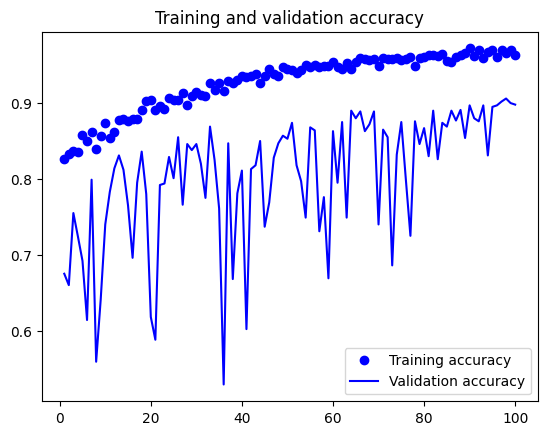

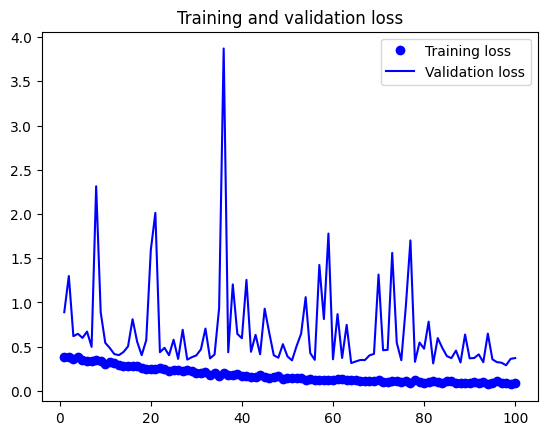

In [25]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()